## Combining the DataFrames

In [100]:
import pandas as pd
import numpy as np

df2 = pd.read_csv("../../annonymizedDatasets/maskedDAIsy_LabCombinedNew.csv", sep="\t")
df_vitals = pd.read_csv("../../annonymizedDatasets/maskedDAIsy_Vitals.csv", sep="\t")
df_age = pd.read_csv("../../annonymizedDatasets/maskedDAIsy_AllDatasetsCombinedWoRepIntakes_v1.tsv", sep = "\t")

### CHEMICAL DATAFRAME

In [101]:
# FILTERING OUT THE RELEVANT COLUMNS
items = ['Kalium', 'Leucocyten', 'ALAT (GPT)', 'ASAT (GOT)', 'Fosfaat anorganisch', 'Magnesium', 'Glucose (n.n.)']

df_items = df2[df2['O_ITEM'].isin(items)]

# df_items.head(10)

In [102]:
# PIVOTING THE DATAFRAME SO THAT ONE LINE IS ONE DATE'S CHEMICAL MEASUREMENT
df_new = df_items.copy()

# Step 1: convert to datetime
df_new['p_DATE_BEPALING'] = pd.to_datetime(df_new['p_DATE_BEPALING']).dt.date

# Drop the unnecessary columns
df_drop = df_new.drop(['STATUS_AANVRAAG', 'O_STATUS_UITSLAG'], axis=1)

# Reorder columns
df_reordered = df_drop.iloc[:, [0, 1, 3, 4, 2, 5, 6]]

df_reordered.rename(columns={'pid': 'PATIENT_ID', 'intid': 'INTAKE_ID','O_ITEM': 'CHEMICAL_VALUE', 'UITSLAG_WAARDE': 'VALUE_RESULT', 'NORMAALWAARDE': 'NORMAL_RANGE', 'p_DATE_BEPALING': 'DATE', 'seq_num-lab': 'SEQUENCE'}, inplace=True)

df_reordered.sort_values(by = 'PATIENT_ID')

df_pivot = df_reordered.pivot_table(index=['PATIENT_ID', 'INTAKE_ID', 'SEQUENCE', 'DATE'], columns='CHEMICAL_VALUE', values='VALUE_RESULT', aggfunc='first')

df_pivot = df_pivot.rename_axis(None, axis=1)

pivoted_df = df_pivot.reset_index()

# Set a new index as the row number
pivoted_df['ROW'] = range(1, len(pivoted_df) + 1)
pivoted_df.set_index('ROW', inplace=True)

val_count = pivoted_df['PATIENT_ID'].value_counts()

pivot_df = pivoted_df[pivoted_df['PATIENT_ID'].isin(val_count[val_count >= 3].index)]

pivot_df


,PATIENT_ID,INTAKE_ID,SEQUENCE,DATE,ALAT (GPT),ASAT (GOT),Fosfaat anorganisch,Glucose (n.n.),Kalium,Leucocyten,Magnesium
ROW,,,,,,,,,,,
2,10,934,1,2140-01-29,26,25,1.22,3.8,4.0,3.6,0.73
3,10,934,2,2140-01-30,25,23,1.11,4.1,4.3,4.1,0.73
4,10,934,3,2140-02-03,32,20,1.37,4.3,4.3,5.0,0.70
5,10,934,4,2140-02-05,26,17,1.25,4.4,4.2,4.4,0.70
6,10,934,5,2140-02-06,24,17,1.23,4.3,4.6,4.5,0.70
...,...,...,...,...,...,...,...,...,...,...,...
5262,1601,1076,24,2140-10-12,NaN,NaN,NaN,NaN,NaN,3.9,NaN
5263,1601,1076,24,2140-10-19,<9,10,1.36,4.6,4.3,NaN,0.75
5264,1601,1076,25,2140-10-19,NaN,NaN,NaN,NaN,NaN,4.3,NaN


### VITALS DATAFRAME (BMI, BLOOD PRESSURE)

In [103]:
# Step 1: convert to datetime
df_vitals['p_DT_METING'] = pd.to_datetime(df_vitals['p_DT_METING'])

# Step 2: Extract the date and time separately
df_vitals['DATE'] = df_vitals['p_DT_METING'].dt.date
df_vitals['TIME'] = df_vitals['p_DT_METING'].dt.time

# Drop the unnecessary columns
df_drop = df_vitals.drop(['Split', 'p_DT_METING', 'TIME'], axis=1)

# Reorder columns
df_reordered = df_drop.iloc[:, [0, 1, 2, 6, 3, 4, 5]]

df_reordered.rename(columns={'pid': 'PATIENT_ID', 'intid': 'INTAKE_ID','O_METING': 'MEASUREMENT ITEM', 'WAARDE1': 'VALUE 1', 'WAARDE2': 'VALUE 2', 'seq_num-vitals': 'SEQUENCE'}, inplace=True)

df_filtered = df_reordered[df_reordered['MEASUREMENT ITEM'].isin(['Body Mass Index', 'Tensie / Pols', 'Temperatuur (c)'])]

df_filtered.sort_values(by = ['PATIENT_ID', 'INTAKE_ID', 'SEQUENCE', 'DATE'], inplace=True)
df_filtered.head(20)

vitals_df = df_filtered.reset_index()

vitals_df.drop('index', axis=1, inplace=True)

# vitals_df

d:\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [104]:
df_melted = vitals_df.melt(id_vars=['PATIENT_ID', 'INTAKE_ID', 'SEQUENCE', 'DATE', 'MEASUREMENT ITEM'],
                     value_vars=['VALUE 1', 'VALUE 2'],
                     var_name='VALUE_TYPE',
                     value_name='VALUE')



# Create a unique identifier for multiple values of the same measurement
df_melted['MEASUREMENT ITEM'] = df_melted['MEASUREMENT ITEM'] + " " + df_melted.groupby(['PATIENT_ID', 'INTAKE_ID', 'SEQUENCE', 'DATE', 'MEASUREMENT ITEM']).cumcount().add(1).astype(str)

# Pivot the table to get the desired structure
df_pivot = df_melted.pivot_table(index=['PATIENT_ID', 'INTAKE_ID', 'SEQUENCE', 'DATE'],
                                 columns='MEASUREMENT ITEM',
                                 values='VALUE',
                                 aggfunc='first')

# Flatten the MultiIndex columns
df_pivot.columns = [col for col in df_pivot.columns]

# Reset index to get a clean DataFrame
df_finals = df_pivot.reset_index()

# Display the transformed DataFrame
df_finals.sort_values(by=['PATIENT_ID', 'INTAKE_ID', 'DATE'], inplace=True)

# df_finals

In [105]:
# Step 1: Calculate BMI
df_finals['Height (m)'] = df_finals['Body Mass Index 1'] / 100
df_finals['BMI'] = df_finals['Body Mass Index 2'] / (df_finals['Height (m)'] ** 2)

# Step 2: Drop the height column (Body Mass Index 1)
df_final1 = df_finals.drop(columns=['Body Mass Index 1'])

# Step 3: Rename the Tensie / Pols columns to Systolic and Diastolic
df_final2 = df_final1.rename(columns={
    'Tensie / Pols 1': 'Systolic',
    'Tensie / Pols 2': 'Diastolic',
    'Temperatuur (c) 1': 'Temperature (C)',
    'Body Mass Index 2': 'Weight (kg)'
})

# Step 4: Reorder the columns as required
df_vitals_final = df_final2.iloc[:, [0, 1, 2, 3, 4, 8, 9, 5, 6, 7]]

# Step 5: Sort the DataFrame by PATIENT_ID, INTAKE_ID, and DATE
df_final = df_vitals_final.sort_values(by=['PATIENT_ID', 'INTAKE_ID', 'DATE'])

# Step 6: Generate new SEQUENCE by grouping by PATIENT_ID and INTAKE_ID and using cumcount
df_final['SEQUENCE'] = df_final.groupby(['PATIENT_ID', 'INTAKE_ID']).cumcount() + 1

# print("Length dataframe: ", len(df_final))
#
# print("\nNaN Counts for each column:")
# print(df_final.isna().sum())

# Display the result to check the first few rows of the final DataFrame
# print(df_final[df_final['PATIENT_ID'] == 3])

# df_final[df_final['PATIENT_ID'] == 3]

In [106]:
# Step 1: Group by PATIENT_ID, INTAKE_ID, and DATE, and aggregate the other columns
df_aggregated = df_final.groupby(['PATIENT_ID', 'INTAKE_ID', 'DATE'], as_index=False).agg({
    'Weight (kg)': 'first',  # Use the first non-null value for Weight
    'Height (m)': 'first',   # Use the first non-null value for Height
    'BMI': 'first',          # Use the first non-null value for BMI
    'Temperature (C)': 'first',  # Use the first non-null value for Temperature
    'Systolic': 'first',     # Use the first non-null value for Systolic
    'Diastolic': 'first'     # Use the first non-null value for Diastolic
})

# Step 2: Recalculate SEQUENCE after aggregation to ensure it's unique
df_aggregated['SEQUENCE'] = df_aggregated.groupby(['PATIENT_ID', 'INTAKE_ID']).cumcount() + 1

# Step 3: Sort the DataFrame by PATIENT_ID, INTAKE_ID, and DATE
df_aggregated = df_aggregated.sort_values(by=['PATIENT_ID', 'INTAKE_ID', 'DATE'])

# Check for any remaining duplicates
print(f"\nAfter Aggregating and Removing Duplicates:")
print(f"Length of DataFrame: {len(df_aggregated)}")

# Optionally check if any duplicates still exist for the same patient and intake
print(df_aggregated[df_aggregated.duplicated(subset=['PATIENT_ID', 'INTAKE_ID', 'DATE'], keep=False)])

df_aggregated


After Aggregating and Removing Duplicates:
Length of DataFrame: 32434
Empty DataFrame
Columns: [PATIENT_ID, INTAKE_ID, DATE, Weight (kg), Height (m), BMI, Temperature (C), Systolic, Diastolic, SEQUENCE]
Index: []


,PATIENT_ID,INTAKE_ID,DATE,Weight (kg),Height (m),BMI,Temperature (C),Systolic,Diastolic,SEQUENCE
0,1,900,2140-02-27,159.6,1.670,57.226864,NaN,NaN,NaN,1
1,1,900,2140-06-25,159.1,1.670,57.047581,NaN,NaN,NaN,2
2,2,697,2138-02-20,46.5,1.680,16.475340,NaN,NaN,NaN,1
3,2,697,2138-02-27,45.9,1.680,16.262755,NaN,NaN,NaN,2
4,2,697,2138-03-20,46.6,1.680,16.510771,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...
32429,1601,1076,2140-12-09,NaN,NaN,NaN,36.3,126.0,86.0,78
32430,1601,1076,2140-12-10,44.3,1.735,14.716508,36.4,114.0,78.0,79
32431,1601,1076,2140-12-15,55.7,1.735,18.503600,NaN,NaN,NaN,80
32432,1606,1637,2143-07-11,39.7,1.680,14.066043,NaN,NaN,NaN,1


### AGE AND ED DATAFRAME

In [107]:
df_age['p_startdate'] = pd.to_datetime(df_age['p_startdate'])
df_age['DATE'] = df_age['p_startdate'].dt.date
df_age['intid'] = df_age['intid'].astype(int)

cols = ['intid', 'seq_num-edeq', 'pid', 'DATE', 'Main-Age', 'Main-Bsex', 'EDtype']

df_clean = df_age.loc[:, cols]

df_clean.rename(columns={'pid': 'PATIENT_ID', 'Main-Age': 'AGE', 'Main-Bsex': 'SEX', 'intid': 'INTAKE_ID', 'seq_num-edeq' : 'SEQUENCE'}, inplace=True)

df_filtered = df_clean[df_clean['EDtype'] == 'Anorexia nervosa']

df_filtered.head()

df_reordered = df_filtered.iloc[:, [2, 0, 1, 3, 4, 5, 6]]

# df_reordered.head(20)

### MERGE DF_CHEM AND DF_AGE_BMI TOGETHER

In [113]:
# since we only want AN patients, we should first filter pivot_df based on all the PID that are still in df_reordered
# so that we only have AN patients in pivot_df before merging
pivot_df = pivot_df[pivot_df['PATIENT_ID'].isin(df_reordered['PATIENT_ID'])]
pivot_df.head()

# filter on dates and patient ID's that are already in the pivot_df
# df_filtered = df_reordered[df_reordered[['PATIENT_ID', 'DATE']].isin(pivoted_df[['PATIENT_ID', 'DATE']].drop_duplicates()).all(axis=1)]

df_merged = pivot_df.merge(df_reordered, on=['PATIENT_ID', 'INTAKE_ID'], how='left')

df_merged = df_merged.iloc[:, [0,1,2,3, 12, 13, 14, 15, 4,5,6,7,8,9,10]]

df_merged.rename(columns={'SEQUENCE_x': 'SEQUENCE', 'DATE_x' : 'DATE'}, inplace=True)

df_merged.drop('DATE_y', axis=1, inplace=True)

df_merged[df_merged['PATIENT_ID'] == 65]

,PATIENT_ID,INTAKE_ID,SEQUENCE,DATE,AGE,SEX,EDtype,ALAT (GPT),ASAT (GOT),Fosfaat anorganisch,Glucose (n.n.),Kalium,Leucocyten,Magnesium
44,65,1168,1,2141-03-10,20.0,Vrouw,Anorexia nervosa,37,49,1.17,4.0,3.2,6.8,1.00
45,65,1168,2,2141-03-11,20.0,Vrouw,Anorexia nervosa,38,64,1.08,4.3,3.4,5.8,1.04
46,65,1168,3,2141-03-12,20.0,Vrouw,Anorexia nervosa,NaN,NaN,NaN,NaN,NaN,5.5,NaN
47,65,1168,3,2141-03-15,20.0,Vrouw,Anorexia nervosa,61,40,1.25,4.2,4.4,NaN,0.85
48,65,1168,4,2141-03-15,20.0,Vrouw,Anorexia nervosa,NaN,NaN,NaN,NaN,NaN,6.8,NaN
49,65,1168,4,2141-03-17,20.0,Vrouw,Anorexia nervosa,88,48,1.44,4.1,4.5,NaN,0.94
50,65,1168,5,2141-03-17,20.0,Vrouw,Anorexia nervosa,NaN,NaN,NaN,NaN,NaN,6.7,NaN
51,65,1168,5,2141-03-18,20.0,Vrouw,Anorexia nervosa,94,51,1.42,3.9,4.4,NaN,0.90
52,65,1168,6,2141-03-18,20.0,Vrouw,Anorexia nervosa,NaN,NaN,NaN,NaN,NaN,7.2,NaN
53,65,1168,6,2141-03-22,20.0,Vrouw,Anorexia nervosa,108,39,1.37,4.5,4.6,NaN,0.88


In [117]:
merged_df = df_merged.groupby(['PATIENT_ID', 'DATE'], as_index=False).agg({
    'INTAKE_ID': 'first',
    'SEQUENCE': 'first',  # Assuming the sequence number is the same within a day
    'AGE': 'first',  # Assuming age remains constant
    'SEX': 'first',  # Assuming sex remains constant
    'EDtype': 'first',  # Assuming EDtype remains constant
    'ALAT (GPT)': 'first',  # First non-null value
    'ASAT (GOT)': 'first',  # First non-null value
    'Fosfaat anorganisch': 'first',  # First non-null value
    'Glucose (n.n.)': 'first',  # First non-null value
    'Kalium': 'first',  # First non-null value
    'Leucocyten': 'first',  # First non-null value
    'Magnesium': 'first',  # First non-null value
})

# Check the result
merged_df[merged_df['PATIENT_ID'] == 65]

,PATIENT_ID,DATE,INTAKE_ID,SEQUENCE,AGE,SEX,EDtype,ALAT (GPT),ASAT (GOT),Fosfaat anorganisch,Glucose (n.n.),Kalium,Leucocyten,Magnesium
44,65,2141-03-10,1168,1,20.0,Vrouw,Anorexia nervosa,37,49,1.17,4.0,3.2,6.8,1.00
45,65,2141-03-11,1168,2,20.0,Vrouw,Anorexia nervosa,38,64,1.08,4.3,3.4,5.8,1.04
46,65,2141-03-12,1168,3,20.0,Vrouw,Anorexia nervosa,None,None,None,None,None,5.5,None
47,65,2141-03-15,1168,3,20.0,Vrouw,Anorexia nervosa,61,40,1.25,4.2,4.4,6.8,0.85
48,65,2141-03-17,1168,4,20.0,Vrouw,Anorexia nervosa,88,48,1.44,4.1,4.5,6.7,0.94
49,65,2141-03-18,1168,5,20.0,Vrouw,Anorexia nervosa,94,51,1.42,3.9,4.4,7.2,0.90
50,65,2141-03-22,1168,6,20.0,Vrouw,Anorexia nervosa,108,39,1.37,4.5,4.6,7.3,0.88
51,65,2141-03-25,1168,7,20.0,Vrouw,Anorexia nervosa,128,42,1.31,4.5,4.4,5.9,0.88
52,65,2141-03-29,1168,8,20.0,Vrouw,Anorexia nervosa,97,23,1.35,4.1,4.5,6.7,0.82
53,65,2141-04-01,1168,9,20.0,Vrouw,Anorexia nervosa,85,23,1.43,4.8,4.4,6.8,0.83


### Final DF Merge asof()

In [79]:
# df_aggregated['DATE'] = pd.to_datetime(df_aggregated['DATE'], errors='coerce')
# df_merged['DATE'] = pd.to_datetime(df_merged['DATE'], errors='coerce')
#
# df_combined = pd.merge_asof(
#     df_merged.sort_values(by = ['DATE']), # Left DataFrame, keep all these rows
#     df_aggregated.sort_values(by = ['DATE']),  # Right DataFrame, try to match these rows
#     on='DATE',
#     by=['PATIENT_ID', 'SEQUENCE', 'INTAKE_ID'],  # merge by these
#     direction='backward',  # Find the nearest match
#     tolerance=pd.Timedelta('1D'),  # Allow a tolerance of 1 day
#     allow_exact_matches= True
# )
#
# no_match_rows = df_combined[df_combined['AGE'].isnull()]
# print(f"Rows without a match from df_merged: {len(no_match_rows)}")
#
# print(f"Length DataFrame: {len(df_combined)}")
#
# print(df_combined.isnull().sum())
# df_combined[df_combined['PATIENT_ID'] == 10]

### THIS DOES NOT WORK
# Check for unmatched rows (where DATE difference > 1 day)
# unmatched_rows = df_combined[df_combined['_merge'] == 'left_only']
# print("\nChecking for unmatched rows:")
# print(unmatched_rows)

In [168]:
### THIS WORKS - NORMAL MERGING

df_aggregated['DATE'] = pd.to_datetime(df_aggregated['DATE'], errors='coerce')
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'], errors='coerce')

# Perform the normal merge on 'DATE', 'PATIENT_ID', 'INTAKE_ID'
df_combined = pd.merge(merged_df, df_aggregated, on=['DATE', 'PATIENT_ID', 'INTAKE_ID'], how='left', suffixes=('_final', '_merged'))

df_combined = df_combined.rename(columns={'SEQUENCE_final': 'SEQUENCE', 'ASAT (GOT)': 'AST (GOT)', 'ALAT (GPT)': 'ALT (GPT)', 'Fosfaat anorganisch': 'Phosphate unorganic', 'Kalium': 'Potassium', 'Leucocyten': 'Leucocytes'})
df_combined = df_combined.drop(columns=['SEQUENCE_merged'])

new_column_order = ['PATIENT_ID', 'INTAKE_ID', 'SEQUENCE', 'DATE', 'AGE', 'SEX', 'EDtype', 'Weight (kg)', 'Height (m)', 'BMI', 'Temperature (C)', 'Systolic', 'Diastolic', 'ALT (GPT)', 'AST (GOT)', 'Phosphate unorganic', 'Glucose (n.n.)', 'Potassium', 'Leucocytes', 'Magnesium']

# Reorder the columns in the DataFrame
df_combined = df_combined[new_column_order]

columns_to_convert = ['ALT (GPT)', 'AST (GOT)', 'Phosphate unorganic', 'Glucose (n.n.)', 'Potassium', 'Leucocytes', 'Magnesium']

# Convert each column to numeric, coercing errors to NaN
df_combined[columns_to_convert] = df_combined[columns_to_convert].apply(pd.to_numeric, errors='coerce')

df_combined = df_combined[df_combined['EDtype'] == "Anorexia nervosa"]

# fill height based on already available height somewhere else in rows for specific patient
df_combined['Height (m)'] = df_combined.groupby('PATIENT_ID')['Height (m)'].transform(lambda x: x.ffill().bfill())

# Convert specific temperature values to NaN
df_combined['Temperature (C)'] = df_combined['Temperature (C)'].replace([43, 33.7], float('nan'))

# Convert systolic and diastolic values of 0 to NaN
df_combined['Systolic'] = df_combined['Systolic'].replace(0, float('nan'))
df_combined['Diastolic'] = df_combined['Diastolic'].replace(0, float('nan'))

# # Display the merged dataframe to check
df_combined

,PATIENT_ID,INTAKE_ID,SEQUENCE,DATE,AGE,SEX,EDtype,Weight (kg),Height (m),BMI,Temperature (C),Systolic,Diastolic,ALT (GPT),AST (GOT),Phosphate unorganic,Glucose (n.n.),Potassium,Leucocytes,Magnesium
0,10,934,1,2140-01-29,26.0,Vrouw,Anorexia nervosa,44.50,1.570,18.053471,36.1,107.0,70.0,26.0,25.0,1.22,3.8,4.0,3.6,0.73
1,10,934,2,2140-01-30,26.0,Vrouw,Anorexia nervosa,45.45,1.570,18.438882,35.2,NaN,NaN,25.0,23.0,1.11,4.1,4.3,4.1,0.73
2,10,934,3,2140-02-03,26.0,Vrouw,Anorexia nervosa,44.50,1.570,18.053471,NaN,NaN,NaN,32.0,20.0,1.37,4.3,4.3,5.0,0.70
3,10,934,4,2140-02-05,26.0,Vrouw,Anorexia nervosa,NaN,1.570,NaN,NaN,NaN,NaN,26.0,17.0,1.25,4.4,4.2,4.4,0.70
4,10,934,5,2140-02-06,26.0,Vrouw,Anorexia nervosa,NaN,1.570,NaN,NaN,NaN,NaN,24.0,17.0,1.23,4.3,4.6,4.5,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,1601,1076,21,2140-09-28,29.0,Vrouw,Anorexia nervosa,42.80,1.735,14.218206,36.4,129.0,85.0,15.0,NaN,1.45,NaN,4.5,4.2,0.76
1918,1601,1076,22,2140-10-05,29.0,Vrouw,Anorexia nervosa,NaN,1.735,NaN,NaN,NaN,NaN,12.0,13.0,1.48,5.1,4.4,4.0,0.76
1919,1601,1076,23,2140-10-12,29.0,Vrouw,Anorexia nervosa,NaN,1.735,NaN,NaN,NaN,NaN,12.0,8.0,1.53,4.5,4.1,3.9,0.75
1920,1601,1076,24,2140-10-19,29.0,Vrouw,Anorexia nervosa,45.70,1.735,15.181589,35.7,125.0,81.0,NaN,10.0,1.36,4.6,4.3,4.3,0.75


In [164]:
df_combined.to_csv('BEP.csv', index=False)

In [155]:
nan_counts = df_combined.isna().sum()

# Display the NaN counts
print("\nDataframe length: ", len(df_combined))
print("\nNaN Counts per Column:")
print(nan_counts)


Dataframe length:  1882

NaN Counts per Column:
PATIENT_ID               0
INTAKE_ID                0
SEQUENCE                 0
DATE                     0
AGE                      0
SEX                      0
EDtype                   0
Weight (kg)            934
Height (m)              48
BMI                    934
Temperature (C)        892
Systolic               898
Diastolic              899
ALT (GPT)               44
AST (GOT)               71
Phosphate unorganic     39
Glucose (n.n.)         419
Potassium               29
Leucocytes              32
Magnesium               41
dtype: int64


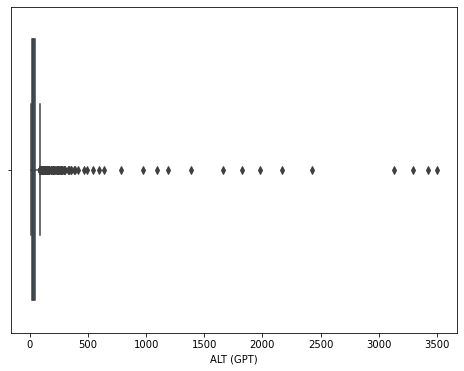

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the boxplot for the 'weight' column
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
sns.boxplot(x=df_combined['ALT (GPT)'])

# Show the plot
plt.show()

In [158]:
unique_values = sorted(df_combined['ALT (GPT)'].dropna().unique())
print(unique_values)

[8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 110.0, 111.0, 112.0, 113.0, 114.0, 117.0, 119.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 138.0, 143.0, 144.0, 146.0, 147.0, 150.0, 152.0, 153.0, 159.0, 161.0, 162.0, 178.0, 182.0, 183.0, 188.0, 195.0, 196.0, 199.0, 203.0, 207.0, 216.0, 220.0, 229.0, 235.0, 237.0, 241.0, 246.0, 247.0, 257.0, 263.0, 269.0, 275.0, 277.0, 279.0, 289.0, 291.0, 292.0, 

In [169]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

# Load the data
df = pd.read_csv('BEP.csv')

print("Original DataFrame with missing values:")
print(df.head())  # Print only the first few rows for readability

# Columns to impute
cols_to_impute = ['Weight (kg)', 'Temperature (C)', 'Systolic',
                  'Diastolic', 'ALT (GPT)', 'AST (GOT)', 'Phosphate unorganic',
                  'Glucose (n.n.)', 'Potassium', 'Leucocytes', 'Magnesium']

# Select only columns that need imputation
df_subset = df[cols_to_impute].copy()

# Initialize and apply MICE imputer
mice_imputer = IterativeImputer()
df_imputed = pd.DataFrame(mice_imputer.fit_transform(df_subset), columns=cols_to_impute)

# Merge imputed values back into the original dataframe
df[cols_to_impute] = df_imputed

# Calculate BMI based on imputed weight
df['BMI'] = df['BMI'].fillna(df['Weight (kg)'] / (df['Height (m)'] ** 2))

# Print results
print("\nDataFrame after MICE Imputation:")
print(df.head())

df.to_csv('BEP_imputed.csv', index=False)

Original DataFrame with missing values:
   PATIENT_ID  INTAKE_ID  SEQUENCE        DATE   AGE    SEX            EDtype  \
0          10        934         1  2140-01-29  26.0  Vrouw  Anorexia nervosa   
1          10        934         2  2140-01-30  26.0  Vrouw  Anorexia nervosa   
2          10        934         3  2140-02-03  26.0  Vrouw  Anorexia nervosa   
3          10        934         4  2140-02-05  26.0  Vrouw  Anorexia nervosa   
4          10        934         5  2140-02-06  26.0  Vrouw  Anorexia nervosa   

   ALT (GPT)  AST (GOT)  Phosphate unorganic  Glucose (n.n.)  Potassium  \
0       26.0       25.0                 1.22             3.8        4.0   
1       25.0       23.0                 1.11             4.1        4.3   
2       32.0       20.0                 1.37             4.3        4.3   
3       26.0       17.0                 1.25             4.4        4.2   
4       24.0       17.0                 1.23             4.3        4.6   

   Leucocytes  Magnesi

d:\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


### Checking Date Overlap

In [43]:
dates_chem = df_check2.index.get_level_values(1).unique().tolist()

dates_vitals = df_check["DATE"].unique().tolist()

dates_chem_dates = [d.date() if isinstance(d, pd.Timestamp) else d for d in dates_chem]

dates_vitals_dates = [d.date() if isinstance(d, pd.Timestamp) else d for d in dates_vitals]

overlap_dates = set(dates_chem_dates).intersection(dates_vitals_dates)

initial_length_chem = len(dates_chem_dates)
initial_length_vitals = len(dates_vitals_dates)
overlap_length = len(overlap_dates)

print("Initial length of dates_chem:", initial_length_chem)
print("Initial length of dates_vitals:", initial_length_vitals)
print("Overlap length:", overlap_length)

print("Overlapping Dates:", overlap_dates)


Initial length of dates_chem: 34
Initial length of dates_vitals: 129
Overlap length: 16
Overlapping Dates: {datetime.date(2139, 11, 13), datetime.date(2139, 12, 23), datetime.date(2140, 1, 27), datetime.date(2139, 12, 30), datetime.date(2139, 11, 28), datetime.date(2139, 11, 14), datetime.date(2139, 11, 25), datetime.date(2139, 12, 16), datetime.date(2140, 1, 20), datetime.date(2139, 11, 11), datetime.date(2139, 11, 27), datetime.date(2139, 11, 18), datetime.date(2139, 12, 27), datetime.date(2140, 1, 13), datetime.date(2139, 10, 31), datetime.date(2139, 10, 30)}


In [48]:
results = []

for pid in df_vitals["PATIENT_ID"].unique():

    if pid in df_vitals["PATIENT_ID"].values and pid in pivot_df.index.get_level_values(0).unique():
        df_check = df_vitals[df_vitals["PATIENT_ID"] == pid]
        df_check2 = pivot_df[pivot_df['PATIENT_ID'] == pid]

        dates_chem = df_check2['DATE'].unique().tolist()
        dates_vitals = df_check["DATE"].unique().tolist()

        dates_chem_dates = [d.date() if isinstance(d, pd.Timestamp) else d for d in dates_chem]
        dates_vitals_dates = [d.date() if isinstance(d, pd.Timestamp) else d for d in dates_vitals]

        overlap_dates = set(dates_chem_dates).intersection(dates_vitals_dates)

        # calculate lengths
        initial_length_chem = len(dates_chem_dates)
        initial_length_vitals = len(dates_vitals_dates)
        overlap_length = len(overlap_dates)

        # calc overlap
        overlap_percentage = (overlap_length / initial_length_chem) * 100 if initial_length_chem > 0 else 0

        results.append({
            "Patient ID": pid,
            "Chem Dates Count": initial_length_chem,
            "Vitals Dates Count": initial_length_vitals,
            "Overlap Count": overlap_length,
            "Overlap Percentage": overlap_percentage,
            "Overlapping Dates": list(overlap_dates)
        })

summary_df = pd.DataFrame(results)

summary_df_sorted = summary_df.sort_values(by="Patient ID").reset_index(drop=True)

overlap_percentage_stats = {
    "Min": summary_df_sorted["Overlap Percentage"].min(),
    "Max": summary_df_sorted["Overlap Percentage"].max(),
    "Mean": summary_df_sorted["Overlap Percentage"].mean(),
    "Median": summary_df_sorted["Overlap Percentage"].median()
}

print("Overlap Percentage Statistics:")
print(overlap_percentage_stats)

summary_df_sorted.head(100)


Overlap Percentage Statistics:
{'Min': 0.0, 'Max': 0.0, 'Mean': 0.0, 'Median': 0.0}


,Patient ID,Chem Dates Count,Vitals Dates Count,Overlap Count,Overlap Percentage,Overlapping Dates
0,2,0,5,0,0.0,[]
1,3,0,4,0,0.0,[]
2,4,0,11,0,0.0,[]
3,5,0,14,0,0.0,[]
4,9,0,1,0,0.0,[]
...,...,...,...,...,...,...
95,151,24,57,0,0.0,[]
96,152,0,10,0,0.0,[]
97,156,0,54,0,0.0,[]
98,158,0,33,0,0.0,[]
